In [3]:
install.packages("tidyverse")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [106]:
library(tidyverse)


In [107]:
# 读取Python生成的文件
data_wide <- read_tsv("GeneExpression_GroupedData.tsv", 
                     col_types = cols(.default = col_character()))

In [108]:
print(data_wide)

# A tibble: 16,358 × 162
   GeneID     Larva__wandering_stage__…¹ Larva__wandering_sta…² Egg__0_days__Egg
   <chr>      <chr>                      <chr>                  <chr>           
 1 +nsd-2     0.5808                     0.2282,0.8697,0.0000,… 2.3524          
 2 -w-2       0.0000                     0.0784,0.0000,0.0000,… 0.0522          
 3 14-3-3zeta 135.1054                   169.3660,156.6670,111… 102.7253        
 4 18w        50.0181                    14.2486,0.0000,0.0000… 0.7838          
 5 3HCD       166.3968                   81.2692,16.2495,10.34… 76.8834         
 6 5h4        0.0000                     0.0000,0.0000,0.0000,… 0.0730          
 7 6pgl       11.3817                    9.9109,14.0877,12.013… 6.4403          
 8 6tox       20.4011                    2.3716,3.0995,4.9437,… 0.0168          
 9 A1         246.2666                   15.0112,0.0000,0.0000… 0.0260          
10 A2         1.8337                     2.0132,0.0000,0.0000,… 0.0521          
# ℹ

In [109]:
# 转换处理流程
data_long <- data_wide %>%
  # 宽表转长表
  pivot_longer(
    cols = -GeneID,
    names_to = "Stage_Tissue",
    values_to = "RPKM_string"
  ) %>%
  # 拆分逗号分隔值
  separate_rows(RPKM_string, sep = ",") %>%
  # 类型转换与过滤
  mutate(RPKM_value = as.numeric(RPKM_string)) %>%
  filter(!is.na(RPKM_value)) %>%
  # 计算分组均值
  group_by(GeneID, Stage_Tissue) %>%
  summarise(
    RPKM_mean = mean(RPKM_value),
    RPKM_sd = sd(RPKM_value),
    .groups = "drop"
  )


In [110]:
print(data_long)

# A tibble: 2,633,638 × 4
   GeneID Stage_Tissue                    RPKM_mean RPKM_sd
   <chr>  <chr>                               <dbl>   <dbl>
 1 +nsd-2 Adult__0h__Developmental_tissue     0.658  NA    
 2 +nsd-2 Adult__1_day__Fat_body              1.90    0.269
 3 +nsd-2 Adult__1_day__Head                  0.945   0.345
 4 +nsd-2 Adult__1_day__Leg                   1.53    0.342
 5 +nsd-2 Adult__1_day__Ovary                 0.232   0.197
 6 +nsd-2 Adult__1_day__Testis                0.735   0.332
 7 +nsd-2 Adult__1_day__Thorax                0.996   0.471
 8 +nsd-2 Adult__1_day__Wing                  1.44    0.208
 9 +nsd-2 Adult__2_days__Gland                0.186  NA    
10 +nsd-2 Adult__4_days__Gland                0.136  NA    
# ℹ 2,633,628 more rows


In [111]:
data_long_parsed <- data_long

In [112]:
data_long_parsed2 <- data_long_parsed %>%
  separate(
    col    = Stage_Tissue,
    into   = c("Stage","Stage-xifen", "Tissue"),
    sep    = "__",
    remove = FALSE  # 保留原列
  )


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = case_when(
      Stage == "Cell" ~ "Egg",
      TRUE                        ~ Stage
    )
  ) %>%
  mutate(
    Tissue = case_when(
      Tissue %in% c("Egg", "Pupa") ~ "Whole_body",  # Egg/Pupa -> Whole_body
      TRUE                        ~ Tissue          # 其他情况保持不变
    )
  )

In [113]:
print(data_long_parsed2)

# A tibble: 2,633,638 × 7
   GeneID Stage_Tissue              Stage `Stage-xifen` Tissue RPKM_mean RPKM_sd
   <chr>  <chr>                     <chr> <chr>         <chr>      <dbl>   <dbl>
 1 +nsd-2 Adult__0h__Developmental… Adult 0h            Devel…     0.658  NA    
 2 +nsd-2 Adult__1_day__Fat_body    Adult 1_day         Fat_b…     1.90    0.269
 3 +nsd-2 Adult__1_day__Head        Adult 1_day         Head       0.945   0.345
 4 +nsd-2 Adult__1_day__Leg         Adult 1_day         Leg        1.53    0.342
 5 +nsd-2 Adult__1_day__Ovary       Adult 1_day         Ovary      0.232   0.197
 6 +nsd-2 Adult__1_day__Testis      Adult 1_day         Testis     0.735   0.332
 7 +nsd-2 Adult__1_day__Thorax      Adult 1_day         Thorax     0.996   0.471
 8 +nsd-2 Adult__1_day__Wing        Adult 1_day         Wing       1.44    0.208
 9 +nsd-2 Adult__2_days__Gland      Adult 2_days        Gland      0.186  NA    
10 +nsd-2 Adult__4_days__Gland      Adult 4_days        Gland      0.136  NA    
# 

In [114]:
stage_levels <- c( "Egg", "Larva", "Pupa", "Adult") 


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = factor(Stage, levels = stage_levels),  # 大时期排序
    Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-")  # 联合字段
  ) %>%
  arrange(Stage, `Stage-xifen`)  # 同一大时期内按细分时期排序

In [115]:
get_earliest_stage_cor_bootstrap <- function(df_grouped, n_boot = 1000, seed = 123) {
  set.seed(seed)
  
  # (a) 数据有效性检查
  df_valid <- df_grouped %>%
    filter(!is.na(Stage), !is.na(`Stage-xifen`))
  
  if (nrow(df_valid) == 0) {
    return(
      tibble(
        Stage = NA,
        `Stage-xifen` = NA,
        Tissue = unique(df_grouped$Tissue),
        cor_median = NA_real_,
        cor_lower = NA_real_,
        cor_upper = NA_real_,
        n_genes = NA_integer_
      )
    )
  }
  
  # (b) 确定最早发育阶段
  earliest_stage <- df_valid %>%
    arrange(Stage, `Stage-xifen`) %>%
    slice(1) %>%
    select(Stage, `Stage-xifen`) %>%
    mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))
  
  # (c) 提取基准期RPKM数据
  df_earliest <- df_valid %>%
    filter(Stage == earliest_stage$Stage[1] & 
           `Stage-xifen` == earliest_stage$`Stage-xifen`[1]) %>%
    select(GeneID, RPKM_earliest = RPKM_mean)
  
  # (d) 构建比较数据集
  df_compare <- df_valid %>%
    filter(!(Stage == earliest_stage$Stage[1] & 
            `Stage-xifen` == earliest_stage$`Stage-xifen`[1])) %>%
    left_join(df_earliest, by = "GeneID") %>%
    filter(!is.na(RPKM_earliest))
  
  # (e) 处理无比较数据的情况
  if (nrow(df_compare) == 0) {
    return(
      tibble(
        Stage = earliest_stage$Stage[1],
        `Stage-xifen` = earliest_stage$`Stage-xifen`[1],
        Tissue = unique(df_grouped$Tissue),
        cor_median = 1,
        cor_lower = 1,
        cor_upper = 1,
        n_genes = nrow(df_earliest)
      )
    )
  }
  
  # (f) 自举法计算相关系数
  cor_boot <- df_compare %>%
    group_by(Stage, `Stage-xifen`) %>%
    group_modify(~ {
      df_stage <- .x
      cor_vec <- numeric(n_boot)
      
      for (i in seq_len(n_boot)) {
        idx <- sample(seq_len(nrow(df_stage)), size = nrow(df_stage), replace = TRUE)
        sample_df <- df_stage[idx, ]
        
        # 有效性检查：确保有变异度
        if (length(unique(sample_df$RPKM_mean)) < 2 || 
            length(unique(sample_df$RPKM_earliest)) < 2) {
          cor_vec[i] <- NA_real_
        } else {
          cor_vec[i] <- cor(sample_df$RPKM_mean, 
                           sample_df$RPKM_earliest, 
                           use = "pairwise.complete.obs")
        }
      }
      
      tibble(
        Tissue = unique(df_stage$Tissue),
        cor_median = median(cor_vec, na.rm = TRUE),
        cor_lower = quantile(cor_vec, 0.025, na.rm = TRUE),
        cor_upper = quantile(cor_vec, 0.975, na.rm = TRUE),
        n_genes = nrow(df_stage)
      )
    })
  
  # (g) 合并基准期数据
  cor_boot_earliest <- tibble(
    Stage = earliest_stage$Stage[1],
    `Stage-xifen` = earliest_stage$`Stage-xifen`[1],
    Tissue = unique(df_compare$Tissue),
    cor_median = 1,
    cor_lower = 1,
    cor_upper = 1,
    n_genes = nrow(df_earliest)
  )
  
  bind_rows(cor_boot_earliest, cor_boot) %>%
    arrange(Stage, `Stage-xifen`)
}


In [116]:
str(data_long_parsed2)

tibble [2,633,638 × 8] (S3: tbl_df/tbl/data.frame)
 $ GeneID        : chr [1:2633638] "+nsd-2" "+nsd-2" "-w-2" "-w-2" ...
 $ Stage_Tissue  : chr [1:2633638] "Cell____Ovary" "Egg____Egg" "Cell____Ovary" "Egg____Egg" ...
 $ Stage         : Factor w/ 4 levels "Egg","Larva",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Stage-xifen   : chr [1:2633638] "" "" "" "" ...
 $ Tissue        : chr [1:2633638] "Ovary" "Whole_body" "Ovary" "Whole_body" ...
 $ RPKM_mean     : num [1:2633638] 1.182 1.067 0.632 10.397 144.027 ...
 $ RPKM_sd       : num [1:2633638] 2.473 1.079 0.761 16.848 105.84 ...
 $ Combined_Stage: chr [1:2633638] "Egg-" "Egg-" "Egg-" "Egg-" ...


In [117]:
psi_data_long_parsed2 <- readRDS("data_long_parsed2.RDS")

In [118]:
str(psi_data_long_parsed2)

tibble [431,412 × 7] (S3: tbl_df/tbl/data.frame)
 $ GeneID        : chr [1:431412] "14-3-3zeta" "ACBP" "AK" "Alg-2" ...
 $ Stage_Tissue  : chr [1:431412] "Egg__0_days__Egg" "Egg__0_days__Egg" "Egg__0_days__Egg" "Egg__0_days__Egg" ...
 $ Stage         : Factor w/ 4 levels "Egg","Larva",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Stage-xifen   : chr [1:431412] "0_days" "0_days" "0_days" "0_days" ...
 $ Tissue        : chr [1:431412] "Whole_body" "Whole_body" "Whole_body" "Whole_body" ...
 $ PSI_value     : num [1:431412] 0.13 0.961 0.105 0.996 0.552 ...
 $ Combined_Stage: chr [1:431412] "Egg-0_days" "Egg-0_days" "Egg-0_days" "Egg-0_days" ...


In [119]:
psi_unique_genes <- unique(psi_data_long_parsed2$GeneID)


In [120]:
# 使用dplyr筛选（推荐）：
library(dplyr)
data_long_parsed2 <- data_long_parsed2 %>% 
  filter(GeneID %in% psi_unique_genes)

In [121]:
str(psi_data_long_parsed2)

tibble [431,412 × 7] (S3: tbl_df/tbl/data.frame)
 $ GeneID        : chr [1:431412] "14-3-3zeta" "ACBP" "AK" "Alg-2" ...
 $ Stage_Tissue  : chr [1:431412] "Egg__0_days__Egg" "Egg__0_days__Egg" "Egg__0_days__Egg" "Egg__0_days__Egg" ...
 $ Stage         : Factor w/ 4 levels "Egg","Larva",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Stage-xifen   : chr [1:431412] "0_days" "0_days" "0_days" "0_days" ...
 $ Tissue        : chr [1:431412] "Whole_body" "Whole_body" "Whole_body" "Whole_body" ...
 $ PSI_value     : num [1:431412] 0.13 0.961 0.105 0.996 0.552 ...
 $ Combined_Stage: chr [1:431412] "Egg-0_days" "Egg-0_days" "Egg-0_days" "Egg-0_days" ...


In [122]:
cor_all <- data_long_parsed2 %>%
  group_by(Tissue) %>%
  nest() %>%
  mutate(
    cor_table = map(
      data,
      ~ get_earliest_stage_cor_bootstrap(.x, n_boot = 1000, seed = 123)
    )
  ) %>%
  select(-data) %>%
  unnest(cols = cor_table)

Warning message:
“There were 160 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_table = map(...)`.
ℹ In group 1: `Tissue = "Developmental_tissue"`.
Caused by warning:
! Unknown or uninitialised column: `Tissue`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 159 remaining warnings.”


In [123]:
str(cor_all)

gropd_df [160 × 7] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ Tissue     : chr [1:160] "Ovary" "Ovary" "Ovary" "Ovary" ...
 $ Stage      : Factor w/ 4 levels "Egg","Larva",..: 1 2 2 2 2 2 4 1 1 1 ...
 $ Stage-xifen: chr [1:160] "" "0_day_of_5_instar" "3_day_of_4_instar" "3_day_of_5_instar" ...
 $ cor_median : num [1:160] 1 0.582 0.513 0.477 0.508 ...
 $ cor_lower  : Named num [1:160] 1 0.52 0.441 0.398 0.438 ...
  ..- attr(*, "names")= chr [1:160] "" "2.5%" "2.5%" "2.5%" ...
 $ cor_upper  : Named num [1:160] 1 0.692 0.641 0.582 0.638 ...
  ..- attr(*, "names")= chr [1:160] "" "97.5%" "97.5%" "97.5%" ...
 $ n_genes    : int [1:160] 10935 10935 10935 10935 10935 10935 10935 10935 10935 10935 ...
 - attr(*, "groups")= tibble [15 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ Tissue: chr [1:15] "Developmental_tissue" "Digestive" "Excretory" "Fat_body" ...
  ..$ .rows : list<int> [1:15] 
  .. ..$ : int [1:10] 47 48 49 50 51 52 53 54 55 56
  .. ..$ : int [1:11] 57 58 59 60 61 62 63 64 65 66 ...
  .. 

In [124]:
# 先数一下每个Tissue的阶段有多少个
tissue_stage_count <- cor_all %>%
  group_by(Tissue) %>%
  summarise(n_stage = n_distinct(Stage))

# 找到至少有3个不同Stage的组织
valid_tissue <- tissue_stage_count %>%
  filter(n_stage >= 2) %>%
  pull(Tissue)

# 筛选 cor_all
cor_all <- cor_all %>%
  filter(Tissue %in% valid_tissue)

In [125]:
cor_all <- cor_all %>%
  mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = unique(data_long_parsed2$Combined_Stage)  # 确保顺序一致
    )
  )

In [146]:
custom_order <- c(
  "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days",  "Egg-36_hours", "Egg-3_days", "Egg-72_hours", "Egg-120_hours","Egg-168_hours",  "Egg-192_hours", "Egg-216_hours", 
  "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours" , "Larva-1_instar", "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar" , "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", "Larva-5_instar","Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar" , "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage","Larva-52h_wandering_stage", 
  "Pupa-stage_5", 
  "Adult-0h","Adult-1_day", "Adult-2_days", "Adult-4_days","Adult-5_days"
)
# 从数据中过滤掉不需要的时期
data_long_parsed2 <- data_long_parsed2 %>%
  filter(Combined_Stage %in% custom_order)

cor_all <- cor_all %>%
  filter(Combined_Stage %in% custom_order)
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 手动指定顺序
    )
  )

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 保持顺序一致
    )
  )

In [147]:
# 设置置信区间范围阈值
threshold <- 0.5

# 剔除置信区间范围过大的点
cor_all_filtered <- cor_all %>%
  filter((cor_upper - cor_lower) <= threshold | is.na(cor_upper - cor_lower))

library(zoo)

# 对每个 Tissue 分组，进行插值平滑处理
cor_all_smoothed <- cor_all_filtered %>%
  group_by(Tissue) %>%
  mutate(
    cor_median_smooth = na.approx(cor_median, na.rm = FALSE),  # 平滑中位数
    cor_lower_smooth = na.approx(cor_lower, na.rm = FALSE),    # 平滑下界
    cor_upper_smooth = na.approx(cor_upper, na.rm = FALSE)     # 平滑上界
  ) %>%
  ungroup()

In [148]:
tissue_color_mapping <- readRDS("tissue_color_mapping.rds")

In [149]:
p <- ggplot(cor_all_smoothed, aes(x = Combined_Stage, y = cor_median_smooth, group = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), 
              alpha = 0.2, color = NA) +
  geom_line(aes(color = Tissue)) +  # 显式声明color映射
  geom_point(aes(color = Tissue)) + # 显式声明color映射
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage",
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_fill_manual(
    values = tissue_color_mapping,
    breaks = names(tissue_color_mapping)
  ) +
  scale_color_manual(  # 新增颜色标度
    values = tissue_color_mapping,
    breaks = names(tissue_color_mapping)
  )


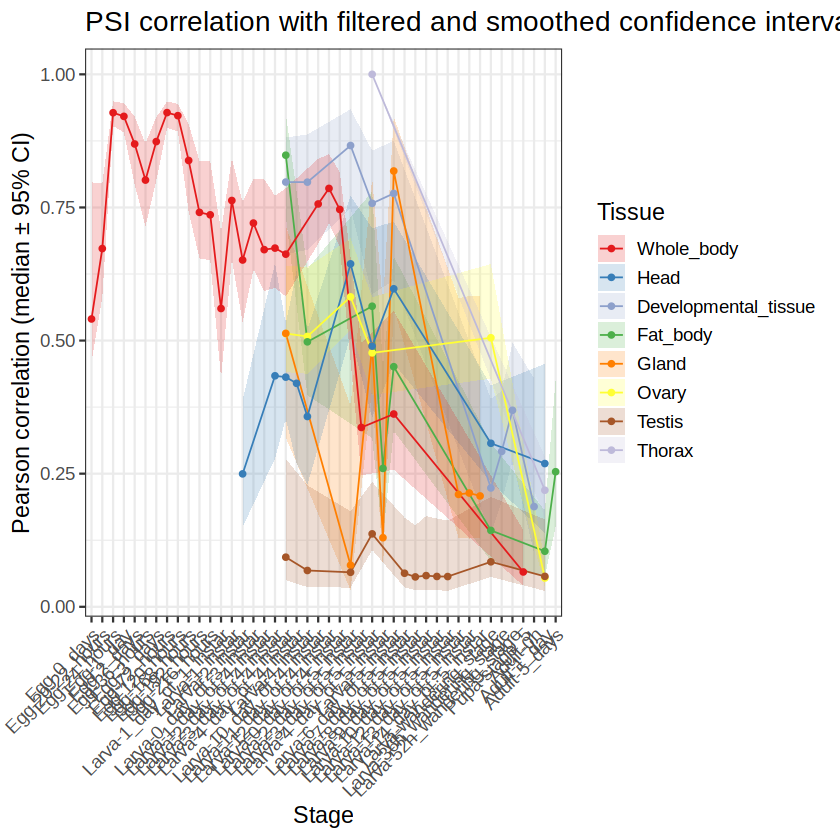

In [150]:
print(p)

In [52]:
ggsave("gene_expression_correlation_plot.pdf", p, width = 12, height = 6, dpi = 300)